# DAML notes
## 5. Linear models for regression
<hr style="border:2px solid black"> </hr>


In [1]:
# RUN THIS CELL FIRST

# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# sklearn
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

# Better plots
plt.rcParams.update(
    {
        "lines.markersize": 10,  # Big points
        "font.size": 15,  # Larger font
        "xtick.major.size": 5.0,  # Bigger xticks
        "ytick.major.size": 5.0,  # Bigger yticks
    }
)


The goal in regression is to learn a model that can predict what a real-valued target $y\in \mathbb{R}$ should be for some data point $\mathbf{x}\in \mathbb{R}^{D}$. It is often appealing to use **linear models** as these are simple, intepretable, and often effective. A linear model takes the form

\begin{equation}
f(\mathbf{x}) =  \mathbf{w}^\top {\mathbf{x}}=\hat{y}
\end{equation}


where $\hat{y}$ is the model's prediction of the target for $\mathbf{x}$.
**When we write the maths for regression, we usually make the assumption that each of our data points has been prepended with a $1$** so that $\mathbf{x}= \begin{bmatrix} 1& x_1& x_2& \dots \end{bmatrix}^\top$.

$\mathbf{w}$ is a learnable vector of parameters $\mathbf{w}= \begin{bmatrix} b& w_1& w_2& \dots \end{bmatrix}^\top$ where $w_1,w_2,\dots$ are weights and $b$ is a bias. The prediction is just a weighted combination of the input features plus the bias:

\begin{equation}
\hat{y}=f(\mathbf{x}) =\mathbf{w}^\top {\mathbf{x}}= b+\sum_{d=1}^{D} w_d x_d
\end{equation}

We use a **training dataset** $\mathfrak{D}_{train}$ to learn what the elements of $\mathbf{w}$ should be. $\mathfrak{D}_{train}$ is a set of $N$ data point-target pairs $\{(\mathbf{x}^{(n)}, y^{(n)})\}_{n=1}^{N}$. It tells our model what the predictions *should be* for a discrete set of points.

The standard machine learning approach is to devise a loss function and find (/learn/fit) the model parameters that minimise it. A loss function is a function of the training data and model parameters that is **low** when the model does what we want.


### 5.1 Simple linear regression

In simple linear regression the input data points are 1D i.e. $x\in\mathbb{R}$. We could for example, want to model the extension of a spring $y$ given the mass $x$ attached to it (ignoring that $x$ is typically the symbol for extension in most literature :)).

Let's generate some synthetic training data $\mathfrak{D}_{train}=\{(x^{(n)}, y^{(n)})\}_{n=1}^{10}$ for this: 


Text(0.5, 1.0, 'Extension vs. mass for a spring')

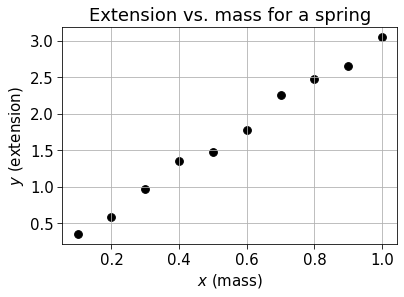

In [2]:
# Seed to keep things the same between runs
np.random.seed(42)

# Let's simulate some measurements, accepting that they will be noisy!
x = np.linspace(0.1, 1, 10)
y = np.linspace(0.1, 1, 10) * 3 + np.random.normal(size=10) * 0.1

# Plot y vs x as a scatter plot
fig, ax = plt.subplots(figsize=[6, 4])
ax.scatter(x, y, s=60, color="k")
ax.grid()
ax.set_xlabel("$x$ (mass)")
ax.set_ylabel("$y$ (extension)")
ax.set_title("Extension vs. mass for a spring")

You may have noticed that I added some noise to the target values. Noise in targets (or indeed, in the actual data) is an inevitability. Perhaps some of these measurements were taken with a different ruler, or incorrectly, or the spring deformed slightly, or the masses were wrong. None of these things happened because this is synthetic data, but hopefully it helped to build the picture!

A linear model in this case is given by

\begin{equation}f(\mathbf{x}) =  \mathbf{w}^\top {\mathbf{x}} =\begin{bmatrix}
b&w
\end{bmatrix} \begin{bmatrix}
1\\x
\end{bmatrix}= w x + b\end{equation}

The neat thing about working in 1D is that we can draw models alongside our data. Let's consider a model with arbitrary parameters $w=5$ and $b=-1$ and produce some plots.


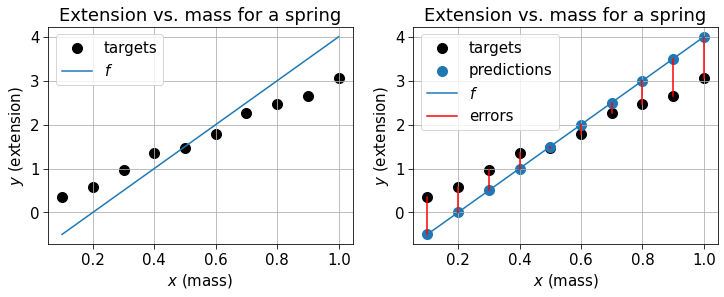

In [3]:
# Do two plots side by side
fig, axes = plt.subplots(1, 2, figsize=[12, 4])

# Made up model
w = 5
b = -1
f = w * x + b

# Plot 0 shows model against points
axes[0].scatter(x, y, color="k")
axes[0].plot(x, f)
axes[0].grid()
axes[0].set_xlabel("$x$ (mass)")
axes[0].set_ylabel("$y$ (extension)")
axes[0].set_title("Extension vs. mass for a spring")
axes[0].legend(["targets", "$f$"])

# Plot 1 makes predictions of training points explicit
axes[1].scatter(x, y, color="k")
axes[1].scatter(x, f)
axes[1].plot(x, f)
axes[1].grid()
axes[1].set_xlabel("$x$ (mass)")
axes[1].set_ylabel("$y$ (extension)")
axes[1].set_title("Extension vs. mass for a spring")
for i in range(len(x)):
    axes[1].plot([x[i], x[i]], [y[i], f[i]], color="r")
axes[1].legend(["targets", "predictions", "$f$", "errors"])

We can see from the left plot that this clearly isn't the best model. In the right model we are explicitly showing training predictions as the blue points along the line. Ideally, we want the vertical distance between these and the targets (black points) to be as small as possible. These distances are depicted using red lines.

### 5.2 Minimising squared error

To achieve this, we can devise a loss function whose value is **low** when the distances between predictions and targets is low. Specifically, we will write out the total squared distance between predictions $\hat{y}^{(1)},\hat{y}^{(2)},\dots,\hat{y}^{(N)}$ and their respective targets $y^{(1)},y^{(2)},\dots,y^{(N)}$, noting that working with squared distances is easier, and equivalent when it comes to minimisation.

\begin{equation}L_{SE} = \sum_n (y^{(n)} - \hat{y}^{(n)})^2\end{equation}

Recalling that $\hat{y} = f(\mathbf{x}) =  \mathbf{w}^\top {\mathbf{x}} $ we can see that this is a function of the training data and the model parameters

\begin{equation}L_{SE}({\mathbf{w}},\mathfrak{D}_{train}) = \sum_n (y^{(n)} - {{\mathbf{w}}^\top  \mathbf{x}^{(n)}})^2\end{equation}

> I tend to write loss functions without explicitly writing what they are a function of. This is likely because I'm not a mathematician or physicist. Note that I also write the model  as $f(\mathbf{x})$ when it should technically be  $f(\mathbf{x,w})$

To learn our model, we want to solve $\underset{\mathbf{w}}{\mathrm{minimise }}\ L_{SE}$. It is easiest to do this by converting the loss function into a vector norm and then using vector calculus, because this works for both simple linear regression and multiple linear regression (see later):

First let's write the targets out in one vector and consider the dataset in matrix form:

\begin{equation}\mathbf{y} =
\begin{bmatrix}
y^{(1)} \\
y^{(2)} \\
y^{(3)} \\
\vdots \\
y^{(N)} \\
\end{bmatrix}\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,
\mathbf{X} =
\begin{bmatrix}
\mathbf{x}^{(1)\top} \\
\mathbf{x}^{(2)\top} \\
\mathbf{x}^{(3)\top} \\
\vdots \\
\mathbf{x}^{(N)\top} 
\end{bmatrix}\end{equation}


Now consider the matrix $\mathbf{y}-\mathbf{Xw}$, bearing in mind that the order of the two vectors in a dot product doesn't matter:

\begin{equation}\mathbf{y}-\mathbf{Xw}=
\begin{bmatrix}
y^{(1)} \\
y^{(2)} \\
y^{(3)} \\
\vdots \\
y^{(N)} \\
\end{bmatrix}
-\begin{bmatrix}
\mathbf{x}^{(1)\top}\mathbf{w} \\
\mathbf{x}^{(2)\top}\mathbf{w}  \\
\mathbf{x}^{(3)\top}\mathbf{w}  \\
\vdots \\
\mathbf{x}^{(N)\top}\mathbf{w}  
\end{bmatrix}
=
\begin{bmatrix}
y^{(1)}-\mathbf{w}^\top\mathbf{x}^{(1)} \\
y^{(2)}-\mathbf{w}^\top\mathbf{x}^{(2)} \\
y^{(3)}-\mathbf{w}^\top\mathbf{x}^{(3)}  \\
\vdots \\
y^{(N)}-\mathbf{w}^\top\mathbf{x}^{(N)} 
\end{bmatrix}\end{equation}

If we take the norm of $\mathbf{y}-\mathbf{Xw}$ and square it, we can see that this is the same as $L_{SE}$.

\begin{equation}\lVert \mathbf{y}-\mathbf{\mathbf{X}{\mathbf{w}}}\rVert^2=(\mathbf{y}-\mathbf{Xw})^\top(\mathbf{y}-\mathbf{Xw})= \sum_n (y^{(n)} - {{\mathbf{w}}^\top  \mathbf{x}^{(n)}})^2=L_{SE}\end{equation}

If we assume fixed training data, $L_{SE}$ is only a function of $\mathbf{w}$. It is a special kind of function known as a **convex** function. A convex function only has one extremum which is a minimum. This means that the optimal model parameters are those for which $\nabla_\mathbf{{\mathbf{w}}} L_{SE}=0$.

Using Equation 84 in the [matrix cookbook](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf) (I don't expect you to do any vector calculus by hand!) we can write:

\begin{equation}L_{SE}=(\mathbf{y}-\mathbf{Xw})^\top(\mathbf{y}-\mathbf{Xw})\end{equation}

\begin{equation}\nabla_\mathbf{{\mathbf{w}}} L_{SE}= -2\mathbf{X} ^\top(\mathbf{y}-\mathbf{X}{\mathbf{w}})=0\end{equation}

This can be rearranged to give our optimal parameters $\mathbf{w^\ast}$ as 

\begin{equation}{\mathbf{w}^\ast}= (\mathbf{X}^\top\mathbf{X})^{-1}\mathbf{X}^\top\mathbf{y}\end{equation}


> Recall that the gradient of some scalar field $f$ (i.e. a function with a scalar output and a vector input) wrt. to its input $\mathbf{x}=\begin{bmatrix} x_1 &  x_2 & \dots& x_D\end{bmatrix}^\top$ can be denoted as $\nabla_\mathbf{{\mathbf{x}}} f$ where $\nabla_\mathbf{{\mathbf{x}}} f=\begin{bmatrix} \frac{\partial f}{\partial x_1} &  \frac{\partial f}{\partial x_2} & \dots& \frac{\partial f}{\partial x_D} \end{bmatrix}^\top$



Let's get these for our spring model above, and repeat the previous plots.

In [4]:
# Explicitly write the data as a matrix
X = x.reshape(-1, 1)

# Prepend a column of ones to this matrix
X = np.hstack([np.ones_like(X), X])

# Compute w* using the above equation
w_star = np.linalg.inv(X.T @ X) @ X.T @ y

print(f"w_star is {w_star}")
print(f"The optimal b is {w_star[0]:.2f}")
print(f"The optimal w is {w_star[1]:.2f}")

w_star is [0.04860132 2.99309963]
The optimal b is 0.05
The optimal w is 2.99


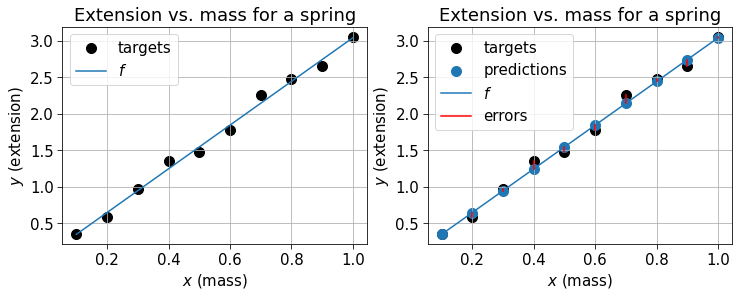

In [5]:
# Do two plots side by side
fig, axes = plt.subplots(1,2,figsize=[12,4])

# Made up model
b,w = w_star
f = w*x+b

# Plot 0 shows model against points
axes[0].scatter(x,y,color='k')
axes[0].plot(x,f)
axes[0].grid()
axes[0].set_xlabel('$x$ (mass)')
axes[0].set_ylabel('$y$ (extension)')
axes[0].set_title('Extension vs. mass for a spring')
axes[0].legend(['targets','$f$'])

# Plot 1 makes predictions of training points explicit
axes[1].scatter(x,y,color='k')
axes[1].scatter(x,f)
axes[1].plot(x,f)
axes[1].grid()
axes[1].set_xlabel('$x$ (mass)')
axes[1].set_ylabel('$y$ (extension)')
axes[1].set_title('Extension vs. mass for a spring')
for i in range(len(x)): 
    axes[1].plot([x[i],x[i]],[y[i],f[i]],color='r')
axes[1].legend(['targets','predictions','$f$','errors'])


This is clearly a much better fit. 

Most of the time on this course, we will use sklearn to create and fit machine learning models. These abstract parameter learning away in a `.fit` method, and computing predictions in a `.predict` method. They also deal with weights and biases, so we don't need to modify our input data by hand.

In [6]:
# sklearn expects a dataset matrix input.
# We don't have to prepend a column of ones as sklearn takes care of the bias
X = x.reshape(-1, 1)

model = LinearRegression()

# fit the model to training data
model.fit(X, y)

# Print weights
print(f"The optimal b is {model.intercept_:.2f}")
print(f"The optimal w is {model.coef_[0]:.2f}")

# Apply the model to some new input
x_new = np.array([0.444]).reshape(-1, 1)
print(f"Model prediction for x={x_new} is {model.predict(x_new)}")

The optimal b is 0.05
The optimal w is 2.99
Model prediction for x=[[0.444]] is [1.37753755]


### 5.3 Multiple linear regression

Most of what we did for simple linear regression carries over to multiple linear regression (they aren't really any different).

Now we have $\mathbf{x}\in\mathbb{R}^D$ and our linear model is 

\begin{equation}f(\mathbf{x}) =  \mathbf{w}^\top {\mathbf{x}} =\begin{bmatrix}
b&w_1&w_2&\dots&w_{D}
\end{bmatrix} \begin{bmatrix}
1\\x_1\\x_2\\\vdots\\x_{D}
\end{bmatrix}=b+\sum_{d=1}^{D} w_d x_d \end{equation}

We can again write the loss as \begin{equation}L_{SE}=(\mathbf{y}-\mathbf{Xw})^\top(\mathbf{y}-\mathbf{Xw})\end{equation}

which has the same optimal parameters 


\begin{equation}{\mathbf{w}^\ast}= (\mathbf{X}^\top\mathbf{X})^{-1}\mathbf{X}^\top\mathbf{y}\end{equation}

As we did in the lecture, we're going to consider multiple regression with the iris dataset. Specifically, we will use petal width as the targets and the other three measurements as features for our data points.

In [7]:
# Load iris dataset as pandas dataframe
df, _ = load_iris(as_frame=True, return_X_y=True)
print(df)

# Extract dataset matrix X and targets y from dataframe
X = df[["sepal length (cm)", "sepal width (cm)", "petal length (cm)"]].values
y = df["petal width (cm)"].values

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                  5.1               3.5                1.4               0.2
1                  4.9               3.0                1.4               0.2
2                  4.7               3.2                1.3               0.2
3                  4.6               3.1                1.5               0.2
4                  5.0               3.6                1.4               0.2
..                 ...               ...                ...               ...
145                6.7               3.0                5.2               2.3
146                6.3               2.5                5.0               1.9
147                6.5               3.0                5.2               2.0
148                6.2               3.4                5.4               2.3
149                5.9               3.0                5.1               1.8

[150 rows x 4 columns]


The whole point of machine learning is to get models that *generalise* to new data. This means we should evaluate models on data that wasn't used to train the model. To achieve this we can split our dataset into a **training set** $\mathfrak{D}_{train}$ and a **test set** $\mathfrak{D}_{test}$. We use the training set to fit the model, and the test set to measure how well it generalises.

Sklearn provides a function for doing this split. Let's go with 80/20 train/test:

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(f"X_train has shape {X_train.shape}")
print(f"y_train has shape {y_train.shape}")
print(f"X_test has shape {X_test.shape}")
print(f"y_test has shape {y_test.shape}")

X_train has shape (120, 3)
y_train has shape (120,)
X_test has shape (30, 3)
y_test has shape (30,)


It is good practice to standardise our data. Although as our test set is meant to represent new data that we don't have access to, we can't use it to compute the statistics for standardisation. We must use the training set for this purpose, and then use those statistics to standardise the test set.

In [9]:
# Create scaler object for X and y.
# This is inefficient as I could have kept X and y together, split, then scaled
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit the scaler to the training data and transform it in one go
X_train = scaler_X.fit_transform(X_train)

# Apply the fitted scaler to the test set
X_test = scaler_X.transform(X_test)

# Repeat for y
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test = scaler_y.transform(y_test.reshape(-1, 1))

We can straightforwardly fit the model to the training set using sklearn:

In [10]:
model = LinearRegression().fit(X_train, y_train)


# Print weights
print(f"The optimal weights are {model.coef_}")
print(f"The optimal b is {model.intercept_}")

The optimal weights are [[-0.23421039  0.10902326  1.2163275 ]]
The optimal b is [2.02859557e-15]


Because we standardised our data, the weights are interpretable. They give the relative importance of each feature towards the prediction.

### 5.4 Evaluating regression models

It's a lot harder to visualise models now we have 3D inputs (and above 4D is close to impossible) so we will instead summarise their performance using scores. The most common scores for evaluating regression models are mean squared error (MSE) and the coefficient of determination ($R^2$).

\begin{equation}L_{MSE} =\frac{1}{N} \sum_n (y^{(n)} - \hat{y}^{(n)})^2\end{equation}

$L_{MSE}$ is just the squared error loss divided by the number of points. It can be evaluated on the training set and/or the test set. We want it to be low.

\begin{equation}R^2 = 1 - \frac{\sum_{n}(y^{(n)} - \hat{y}^{(n)})^2}{\sum_{n}(y^{(n)} - \bar{y})^2}\end{equation}

$R^2$ is 1 minus the reduction in squared error when you use the model's predictions instead of the target mean $\bar{y}$. We want it to be high. It is what we will use most of the time, and can be maximally 1. Unlike MSE, it isn't sensitive to the scaling applied to your data. 

In [11]:
print(f"Train MSE is {mean_squared_error(y_train,model.predict(X_train)):.3f}")
print(f"Test MSE is {mean_squared_error(y_test,model.predict(X_test)):.3f}")

print(f"Train R^2 is {r2_score(y_train,model.predict(X_train)):.3f}")
print(f"Test R^2 is {r2_score(y_test,model.predict(X_test)):.3f}")

Train MSE is 0.062
Test MSE is 0.092
Train R^2 is 0.938
Test R^2 is 0.933


This model has a high $R^2$ on the test set, so can generalise to new data (which is want we want!). Note that $R^2$ is the default score for regression models in sklearn. This means we can compute it directly using the `.score` method as follows:

In [12]:
print(f"Train R^2 is {model.score(X_train, y_train):.3f}")
print(f"Test R^2 is {model.score(X_test, y_test):.3f}")

Train R^2 is 0.938
Test R^2 is 0.933


### 5.5 Polynomial regression

Let's consider a training set $\mathfrak{D}_{train}=\{(x^{(n)}, y^{(n)})\}_{n=1}^{10}$ where fitting a line won't work.

(-2.0, 2.0)

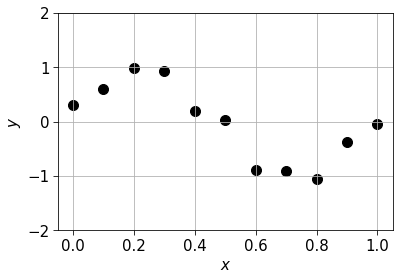

In [13]:
# Random seed to keep everything the same each time
np.random.seed(14)

# Synthetic data
X = np.linspace(0, 1, 11)
y = np.sin(2 * np.pi * X) + np.random.normal(0, 0.2, size=len(X))

# Plot y vs x as a scatter plot
fig, ax = plt.subplots()
ax.scatter(X, y, color="k")
ax.grid()
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

# Setting the ylimit so high function values don't distort our plots
ax.set_ylim(-2, 2)

Let's instead fit a polynomial of degree $M$: \begin{equation}\hat{y}=f(x) = b+\sum_{m=1}^{M} w_m x^m\end{equation}

If we define $\phi(\mathbf{x}) =\begin{bmatrix}
1&x&x^2&\dots&x^{M}\\
\end{bmatrix}^\top$  and write ${{\mathbf{w}}}= 
\begin{bmatrix}
b&w_1&w_2&\dots&w^{M}
\end{bmatrix}^{\top }$ then we have $f(\mathbf{x}) =  {\mathbf{w}}^\top \phi({\mathbf{x}})$.

The model is still linear as its output is a weighted sum of the (new) inputs. 

Our objective is once again $\underset{\mathbf{w}}{\mathrm{minimise }}\ L_{SE}$, and we can use most of the same maths as before to do it. If we define \begin{equation}\mathbf{\Phi} =
\begin{bmatrix}
\phi(\mathbf{x}^{(1)} )^\top \\
\phi(\mathbf{x}^{(2)} )^\top \\
\phi(\mathbf{x}^{(3)} )^\top \\
\vdots \\
\phi(\mathbf{x}^{(N)})^\top  )
\end{bmatrix}
\end{equation} then we get \begin{equation}L_{SE} = \sum_n (y^{(n)} - \hat{y}^{(n)})^2=\lVert \mathbf{y}-\mathbf{\mathbf{\Phi }{\mathbf{w}}}\rVert^2\end{equation} with solution \begin{equation}{\mathbf{w}^\ast}= (\mathbf{\Phi}^\top\mathbf{\Phi})^{-1}\mathbf{\Phi}^\top\mathbf{y}\end{equation}

Let's first look at a model for $M=3$. Fortunately, sklearn provides an easy way to produce polynomial features through [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html).

In [14]:
# Write X as a matrix
X = X.reshape(-1, 1)

# Create an object that lets us transform, and then apply the transformation to our data for M=3
phi = PolynomialFeatures(3, include_bias=False)
P = phi.fit_transform(X)

# Have a look at P to make sure it makes sense.
# We do not have a column of 1s as this will be included in the model bias.
print(P)

[[0.    0.    0.   ]
 [0.1   0.01  0.001]
 [0.2   0.04  0.008]
 [0.3   0.09  0.027]
 [0.4   0.16  0.064]
 [0.5   0.25  0.125]
 [0.6   0.36  0.216]
 [0.7   0.49  0.343]
 [0.8   0.64  0.512]
 [0.9   0.81  0.729]
 [1.    1.    1.   ]]


We can fit the model just by using `LinearRegression` with these features. Note that sklearn makes no assumptions about the input data at all! It just asks for

>`X`{array-like, sparse matrix} of shape (n_samples, n_features)

This can be the *raw* training data, or feature transformations thereof.

In [15]:
model = LinearRegression().fit(P, y)

Let's plot our model to see how it does.

(-1.2, 1.2)

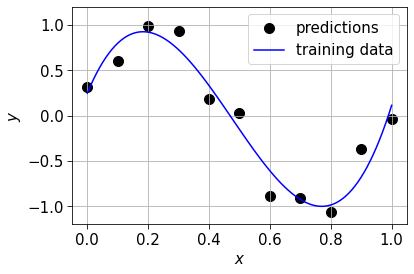

In [16]:
# Crate some dummy points for plotting and apply our model to them
X_dummy = np.linspace(0, 1, 100).reshape(-1, 1)
fx_dummy = model.predict(phi.fit_transform(X_dummy))

# Plot y vs x as a scatter plot
fig, ax = plt.subplots()
ax.scatter(X, y, color="k")

# Plot dummy points and predictions to show function
ax.plot(X_dummy, fx_dummy, color="b")

ax.grid()
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
plt.legend(["predictions", "training data"])

# Setting the ylimit so high function values don't distort our plots
ax.set_ylim(-1.2, 1.2)

Let's see what the model would look like for other values of $M$. We'll produce a plot with multiple figures for $M=\{1,2,3,11\}$.

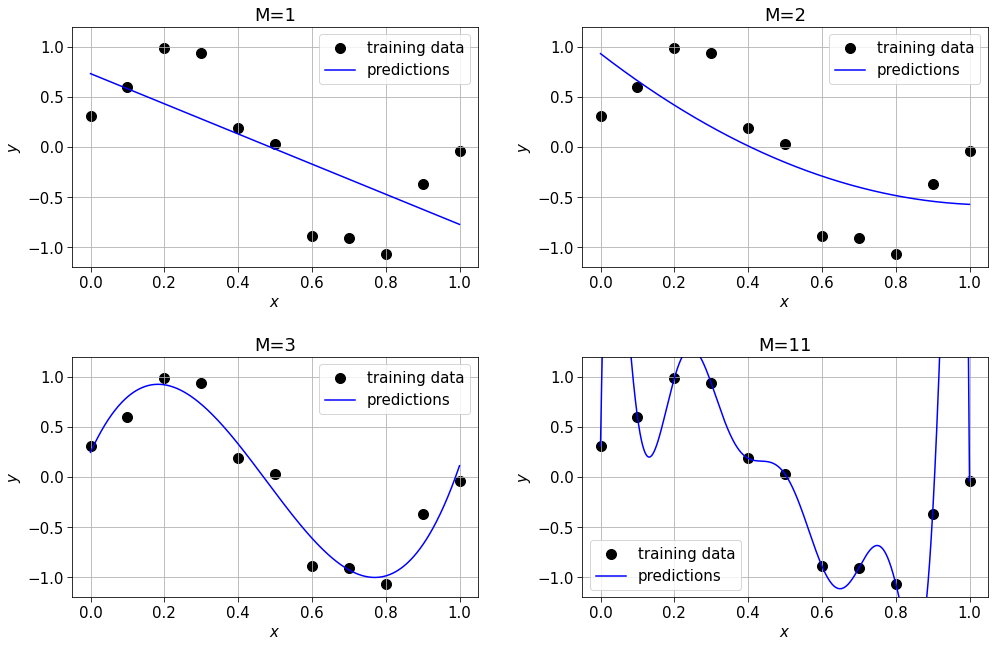

In [17]:
# Values of M we are going to try out

# Create a list to store different models
models = []

# Create a list that contains the M values to try out
M_values = [1, 2, 3, 11]


# Plot for each model
fig, axes = plt.subplots(2, 2, figsize=[15, 10])

# Flattening the axes means we can index it like axes[0] axes[1] etc.
axes = axes.flatten()

# Padding to stop subplots clashing
fig.tight_layout(pad=4)

for i, m in enumerate(M_values):
    phi = PolynomialFeatures(m, include_bias=False)
    P = phi.fit_transform(X)
    model = LinearRegression().fit(P, y)

    # Make dummy points and fit model to them
    x_dummy = np.linspace(0, 1, 1000).reshape(-1, 1)
    fx_dummy = model.predict(phi.fit_transform(x_dummy))

    # Plot y vs x as a scatter plot
    axes[i].scatter(X, y, color="k")

    # Plot predictions as a curve
    axes[i].plot(x_dummy, fx_dummy, color="b")

    axes[i].grid()
    axes[i].set_xlabel("$x$")
    axes[i].set_ylabel("$y$")
    axes[i].legend(["training data", "predictions"])
    axes[i].set_title(f"M={M_values[i]}")
    axes[i].set_ylim(-1.2, 1.2)

The $M=1$ and $M=2$ models does not have the capacity to fit the function. They have *underfitted*. In contrast, the $M=11$ model has  overfit to the noisy data points.  

In this particular example, the $M=3$ model looks like the best fit; it does appear almost sinusoidal. However, it only has 4 parameters. There will exist more complicated functions where we will need more!

### 5.6 Linear regression with regularisation



We want our model to have sufficient capacity to represent the function we care about, however the capacity in question is rarely obvious! What we could do is use a high capacity model to avoid underfitting, and then **regularise** this model to reduce the risk of overfitting. This is done by adding a regularisation term to our loss function. If this penalises the L2 norm of our weights then we call the whole thing "ridge regression".

\begin{equation}L_{ridge}(\mathbf{w}) = \underbrace{\lVert \mathbf{y}-\mathbf{\Phi w}\rVert^2  }_{SE} +\underbrace{ \lambda  \lVert \mathbf{w}\rVert^2 }_{regularisation}\end{equation}

The $\mathbf{w}$ that minimises this is \begin{equation}\mathbf{w} = (\mathbf{\Phi}^\top\mathbf{\Phi}+\lambda I)^{-1}\mathbf{\Phi}^\top\mathbf{y}\end{equation}

> Remember that you can view $\mathbf{X}$ and $\mathbf{\Phi}$ are being interchangeable in these equations

Recall from the lecture that we don't regularise the bias parameter - sklearn won't either!

Let's perform ridge regression to regularise a model for $M=11$. We can see from above that without regularisation it overfits badly.

We can again use sklearn to do this with its [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) class. The main difference here is that in sklearn the regularisation coefficent is refered to as `alpha` instead of $\lambda$. 

In [18]:
# M=11 model
phi = PolynomialFeatures(11, include_bias=False)
P = phi.fit_transform(X)

# Fit model
model = Ridge(alpha=0.001)
model.fit(P, y)

Ridge(alpha=0.001)

(-1.2, 1.2)

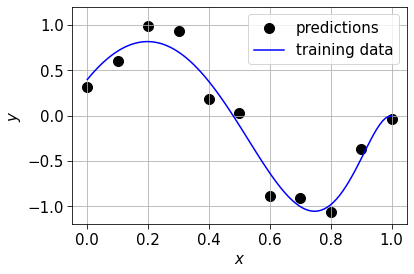

In [19]:
# Create some dummy points for plotting and apply our model to them
X_dummy = np.linspace(0, 1, 100).reshape(-1, 1)
fx_dummy = model.predict(phi.fit_transform(X_dummy))

# Plot y vs x as a scatter plot
fig, ax = plt.subplots()
ax.scatter(X, y, color="k")

# Plot dummy points and predictions to show function
ax.plot(X_dummy, fx_dummy, color="b")

ax.grid()
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
plt.legend(["predictions", "training data"])

# Setting the ylimit so high function values don't distort our plots
ax.set_ylim(-1.2, 1.2)

We can see that our regularised model closer resembles the original function. Sklearn also provides functionality for [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso) regression, which you will use in the lab. You will also explore using a **validation set** for hyperparameter tuning.

<hr style="border:2px solid black"> </hr>

#### Written by Elliot J. Crowley and &copy; The University of Edinburgh 2022-24